# Demo: Control of wheel angle with tracking

#### Import modules and configure the notebook

In [1]:
# These are standard modules
import time
import numpy as np
import sympy as sym
from scipy.signal import place_poles
from scipy import linalg
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown

# This is a custom interface to the pybullet simulator
import ae353_wheel_tracking

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Oct 28 2022 16:21:09


#### Choose parameter values

The equation of motion is

$$c_1 \ddot{q} = \tau - (c_2 \sin \phi) \sin q$$

where

* $q$ is the wheel angle
* $\tau$ is the wheel torque, i.e., the torque applied to the wheel by a motor on the ground
* $\phi$ is the "roll angle" of the ground with respect to horizontal

and where the values of $c_1$ and $c_2$ are given as follows:

In [2]:
# Values of c1 and c2 for the example (do not change)
c1 = 1.0
c2 = 2.0

# Values of other parameters that are given
g = 9.81 # <-- acceleration of gravity
r = 0.35 # <-- distance from wheel axis to marker (i.e., to the mass)

# Values of other parameters that correspond to the coefficients c1 and c2 that we chose
m = c2 / (g * r)   # <-- set in code
J = c1 - m * r**2  # <-- set in URDF
print(f'm = {m}\nJ = {J}')

m = 0.582495995340032
J = 0.928644240570846


#### Create simulator

Create an instance of the `Simulator` class with particular values of `roll` and `mass`.

In [3]:
simulator = ae353_wheel_tracking.Simulator(
    display=True,
    roll=0.,
    mass=m,
    seed=None,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


#### Define functions to plot results

This function plots results in terms of nonlinear states and inputs.

In [4]:
def show_results(data, q_e, v_e, tau_e):
    t = data['t']
    q = data['wheel_angle']
    v = data['wheel_velocity']
    tau = data['wheel_torque']
    tau_cmd = data['wheel_torque_command']
    q_meas = data['measured_wheel_angle']
    q_des = data['desired_wheel_angle']
    xhat = data['xhat']
    q_est = xhat[:, 0] + q_e
    v_est = xhat[:, 1] + v_e

    fig, (ax_q, ax_v, ax_tau) = plt.subplots(
        3, 1, figsize=(10, 8), sharex=True,
    )

    ax_q.plot(t, q, label=r'$q$', linewidth=4)
    ax_q.plot(t, q_est, '--', label=r'$q$ (estimated)', linewidth=4)
    ax_q.plot(t, q_meas, '.', markersize=1, label=r'$q$ (measured)')
    ax_q.plot(t, q_des, ':', label=r'$q$ (desired)')
    ax_q.plot(t, q_e * np.ones_like(t), ':', label=r'$q_e$', linewidth=3, color='C3')
    ax_v.plot(t, v, label=r'$v$', linewidth=4)
    ax_v.plot(t, v_est, '--', label=r'$v$ (estimated)', linewidth=4)
    ax_v.plot(t, v_e * np.ones_like(t), ':', label=r'$v_e$', linewidth=3, color='C3')
    ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
    ax_tau.plot(t, tau_cmd, '-.', label=r'$\tau$ (command)', linewidth=3, color='C6')
    tau_max = np.ones_like(t) * simulator.tau_max
    ax_tau.plot(t, tau_max,
                '--', label=r'$\tau$ (max)', linewidth=2, color='C2', zorder=0)
    ax_tau.plot(t, - tau_max,
                '--', linewidth=2, color='C2', zorder=0)

    ax_q.grid()
    ax_q.legend(fontsize=14, ncol=4, loc='upper right')
    ax_q.tick_params(labelsize=14)
    ax_q.set_ylim(np.min(q_des) - 0.5, np.max(q_des) + 0.5)

    ax_v.grid()
    ax_v.legend(fontsize=14, ncol=3, loc='upper right')
    ax_v.tick_params(labelsize=14)
    ax_v.set_ylim(v_e - 1., v_e + 1.)

    ax_tau.grid()
    ax_tau.legend(fontsize=14, ncol=3, loc='upper right')
    ax_tau.tick_params(labelsize=14)
    ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

    ax_tau.set_xlabel('time (s)', fontsize=14)
    ax_tau.set_xlim([data['t'][0], data['t'][-1]])

    fig.tight_layout()
    plt.show()

#### Implement controller and observer (with tracking)

In [5]:
class Controller:
    def __init__(self, A, B, C, K, L, q_e, v_e, tau_e, get_desired_wheel_angle):
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.q_e = q_e
        self.v_e = v_e
        self.tau_e = tau_e
        
        self.dt = 0.01
        
        self.get_desired_wheel_angle = get_desired_wheel_angle
        
        self.variables_to_log = ['xhat', 'desired_wheel_angle']
    
    def reset(self):
        self.desired_wheel_angle = self.get_desired_wheel_angle(0.)
        
        self.xhat = np.array([
            self.desired_wheel_angle - self.q_e,
            0.,
        ])
    
    def run(self, t, measured_wheel_angle):
        """
        INPUTS
         t = current time (s)
         measured_wheel_angle = measured angle of wheel from sensors (rad)
         
        OUTPUTS
         wheel_torque = torque applied to wheel by motor on ground (N m)
        """
        
        # Get desired wheel angle
        self.desired_wheel_angle = self.get_desired_wheel_angle(t)
        
        # Get desired state
        xdes = np.array([
            self.desired_wheel_angle - self.q_e,
            self.v_e                 - self.v_e,
        ])
        
        # Get input
        u = - self.K @ (self.xhat - xdes)
        
        # Get measured wheel angle (sensors)
        q = measured_wheel_angle
        
        # Get output
        y = np.array([
            q - self.q_e,
        ])
        
        # Get state estimate
        self.xhat += self.dt * (
            self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
        )
        
        # Get torque (actuators)
        wheel_torque = u[0] + self.tau_e
        
        return wheel_torque

# Results without gravity

#### Set roll angle

In [6]:
simulator.set_roll(0.)

#### Do control design

Derive state-space model.

In [8]:
# Define symbolic variables
q, v, tau = sym.symbols('q, v, tau')

# Define ODEs
f = sym.Matrix([
    v,
    tau / c1,
])

# Convert floats to rationals
f = sym.nsimplify(f, rational=True)

# Choose equilibrium point
(q_e, v_e, tau_e) = (0., 0., 0.)

# Linearize
A_num = sym.lambdify([q, v, tau], f.jacobian([q, v]))
A = A_num(q_e, v_e, tau_e).astype(float)
B_num = sym.lambdify([q, v, tau], f.jacobian([tau]))
B = B_num(q_e, v_e, tau_e).astype(float)

# Show result
print(f'A =\n{A}\n\nB =\n{B}')

A =
[[0. 1.]
 [0. 0.]]

B =
[[0.]
 [1.]]


Design controller by eigenvalue placement.

In [9]:
K = signal.place_poles(A, B, [-4., -5.]).gain_matrix
print(f'K =\n{K}')

K =
[[20.  9.]]


#### Do observer design

Derive state-space model.

In [10]:
# Define nonlinear model
g = sym.Matrix([q])

# Convert floats to rationals
g = sym.nsimplify(g, rational=True)

# Linearize
C_num = sym.lambdify([q, v, tau], g.jacobian([q, v]))
C = C_num(q_e, v_e, tau_e).astype(float)
D_num = sym.lambdify([q, v, tau], g.jacobian([tau]))
D = D_num(q_e, v_e, tau_e).astype(float)

# Show result
print(f'C =\n{C}\n\nD =\n{D}')

C =
[[1. 0.]]

D =
[[0.]]


Design observer by eigenvalue placement.

In [11]:
L = signal.place_poles(A.T, C.T, [-6., -7.]).gain_matrix.T
print(L)

[[13.]
 [42.]]


Test controller with desired wheel angle of $q_\text{des} = 0$.

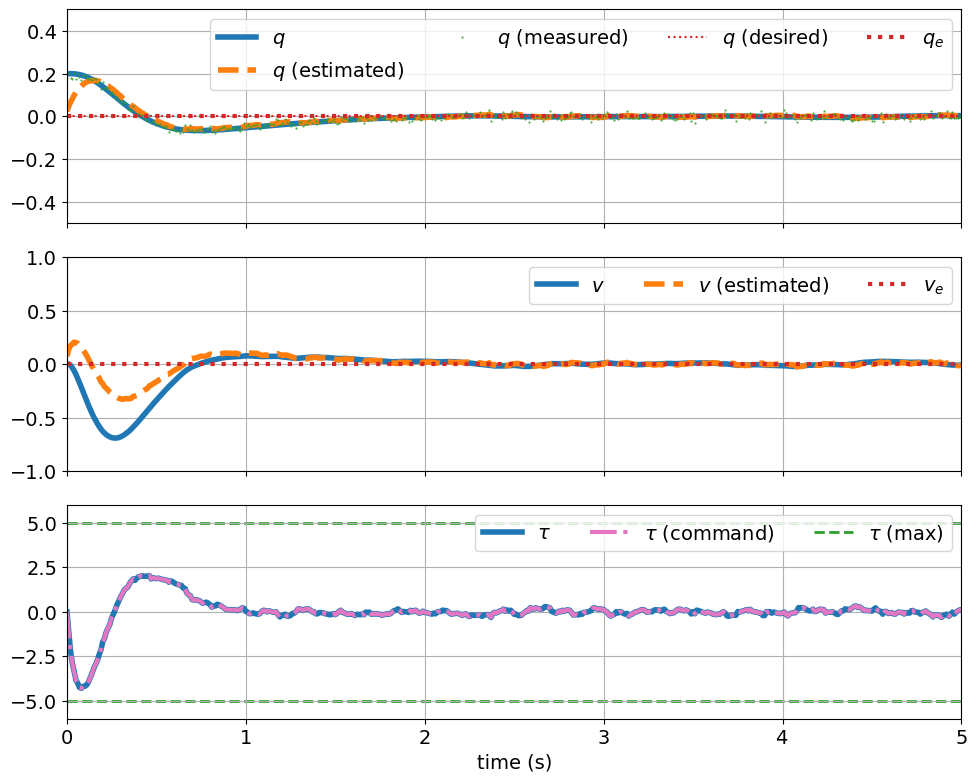

In [12]:
# Define function to get desired wheel angle
get_desired_wheel_angle = lambda t: 0.

# Create controller
controller = Controller(A, B, C, K, L, q_e, v_e, tau_e, get_desired_wheel_angle)

# Choose initial conditions
(q_i, v_i) = (get_desired_wheel_angle(0.) + 0.2, v_e)

# Reset controller
controller.reset()

# Reset simulator
simulator.reset(
    wheel_angle=q_i,
    wheel_velocity=v_i,
    sensor_noise=0.01,
)

# Reset controller
controller.reset()

# Run simulator
data = simulator.run(
    controller,
    max_time=5.0,
)

# Show results
show_results(data, q_e, v_e, tau_e)

Test controller with desired wheel angle of $q_\text{des} = \pi$.

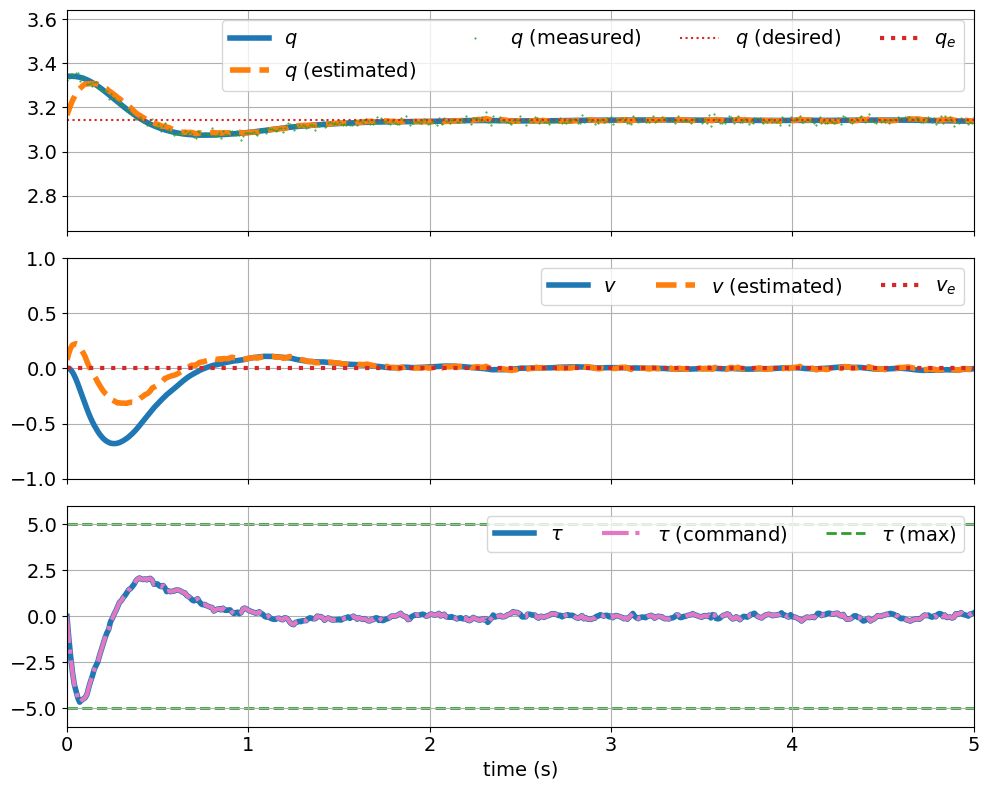

In [13]:
# Define function to get desired wheel angle
get_desired_wheel_angle = lambda t: np.pi

# Create controller
controller = Controller(A, B, C, K, L, q_e, v_e, tau_e, get_desired_wheel_angle)

# Choose initial conditions
(q_i, v_i) = (get_desired_wheel_angle(0.) + 0.2, v_e)

# Reset controller
controller.reset()

# Reset simulator
simulator.reset(
    wheel_angle=q_i,
    wheel_velocity=v_i,
    sensor_noise=0.01,
)

# Reset controller
controller.reset()

# Run simulator
data = simulator.run(
    controller,
    max_time=5.0,
)

# Show results
show_results(data, q_e, v_e, tau_e)

Test controller with desired wheel angle of

$$q_\text{des}(t) = (\pi / 2) \sin\left((2\pi / 20) t\right).$$

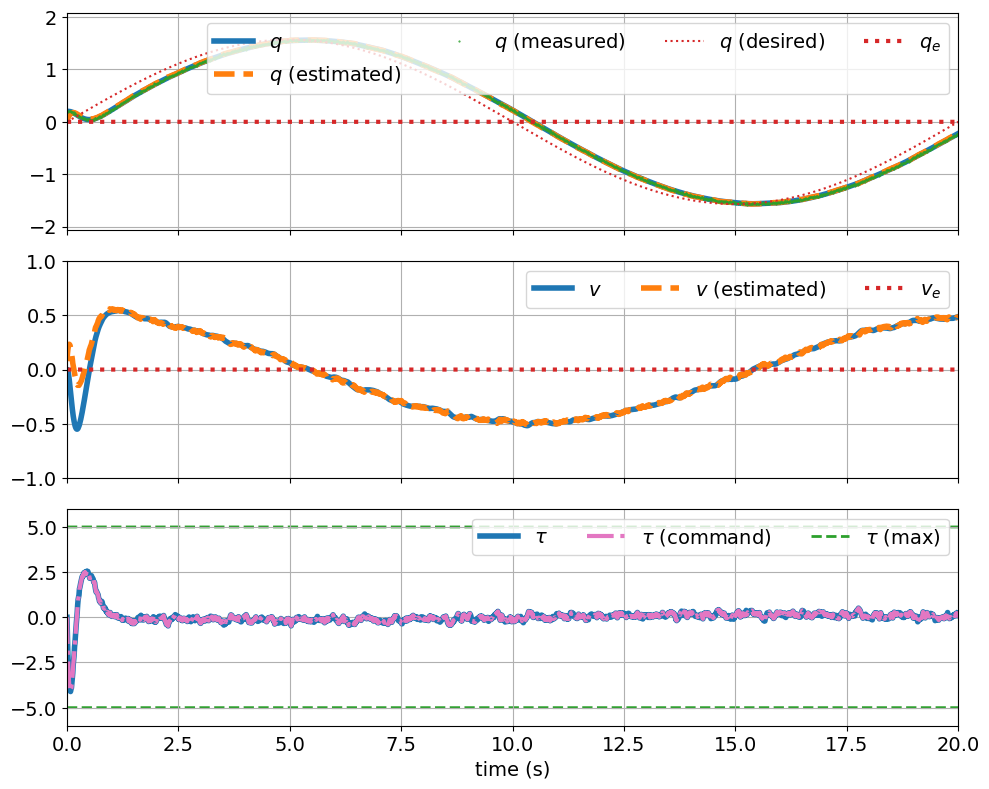

In [14]:
# Define function to get desired wheel angle
get_desired_wheel_angle = lambda t: (np.pi / 2) * np.sin((2 * np.pi / 20) * t)

# Create controller
controller = Controller(A, B, C, K, L, q_e, v_e, tau_e, get_desired_wheel_angle)

# Choose initial conditions
(q_i, v_i) = (get_desired_wheel_angle(0.) + 0.2, v_e)

# Reset controller
controller.reset()

# Reset simulator
simulator.reset(
    wheel_angle=q_i,
    wheel_velocity=v_i,
    sensor_noise=0.01,
)

# Reset controller
controller.reset()

# Run simulator
data = simulator.run(
    controller,
    max_time=20.0,
)

# Show results
show_results(data, q_e, v_e, tau_e)

# Results with gravity

#### Set roll angle in simulator

In [15]:
simulator.set_roll(np.pi / 2)

#### Do control design

Derive state-space model.

In [25]:
# Define symbolic variables
q, v, tau = sym.symbols('q, v, tau')

# Define ODEs
f = sym.Matrix([
    v,
    (tau - c2 * sym.sin(q)) / c1,
])

# Convert floats to rationals
f = sym.nsimplify(f, rational=True)

# Choose equilibrium point
(q_e, v_e, tau_e) = (0., 0., 0.)

# Linearize
A_num = sym.lambdify([q, v, tau], f.jacobian([q, v]))
A = A_num(q_e, v_e, tau_e).astype(float)
B_num = sym.lambdify([q, v, tau], f.jacobian([tau]))
B = B_num(q_e, v_e, tau_e).astype(float)

# Show result
print(f'A =\n{A}\n\nB =\n{B}')

A =
[[ 0.  1.]
 [-2.  0.]]

B =
[[0.]
 [1.]]


In [26]:
# Define symbolic variables
q, v, tau = sym.symbols('q, v, tau')

# Define ODEs
f = sym.Matrix([
    v,
    (tau - c2 * sym.sin(q)) / c1,
])

# Convert floats to rationals
f = sym.nsimplify(f, rational=True)

# Choose equilibrium point
(q_e, v_e, tau_e) = (np.pi, 0., 0.)

# Linearize
A_num = sym.lambdify([q, v, tau], f.jacobian([q, v]))
A = A_num(q_e, v_e, tau_e).astype(float)
B_num = sym.lambdify([q, v, tau], f.jacobian([tau]))
B = B_num(q_e, v_e, tau_e).astype(float)

# Show result
print(f'A =\n{A}\n\nB =\n{B}')

A =
[[0. 1.]
 [2. 0.]]

B =
[[0.]
 [1.]]


Design controller by eigenvalue placement.

In [17]:
K = signal.place_poles(A, B, [-4., -5.]).gain_matrix
print(f'K =\n{K}')

K =
[[18.  9.]]


#### Do observer design

Derive state-space model.

In [18]:
# Define nonlinear model
g = sym.Matrix([q])

# Convert floats to rationals
g = sym.nsimplify(g, rational=True)

# Linearize
C_num = sym.lambdify([q, v, tau], g.jacobian([q, v]))
C = C_num(q_e, v_e, tau_e).astype(float)
D_num = sym.lambdify([q, v, tau], g.jacobian([tau]))
D = D_num(q_e, v_e, tau_e).astype(float)

# Show result
print(f'C =\n{C}\n\nD =\n{D}')

C =
[[1. 0.]]

D =
[[0.]]


Design observer by eigenvalue placement.

In [19]:
L = signal.place_poles(A.T, C.T, [-6., -7.]).gain_matrix.T
print(L)

[[13.]
 [40.]]


Test controller with desired wheel angle of $q_\text{des} = 0$.

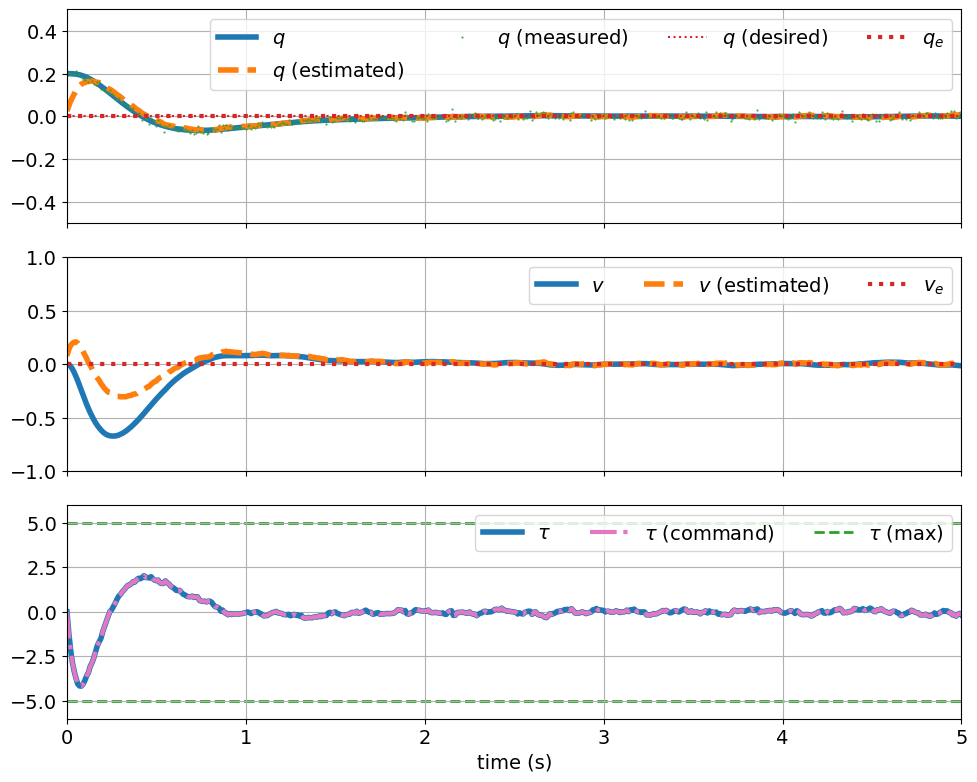

In [20]:
# Define function to get desired wheel angle
get_desired_wheel_angle = lambda t: 0.

# Create controller
controller = Controller(A, B, C, K, L, q_e, v_e, tau_e, get_desired_wheel_angle)

# Choose initial conditions
(q_i, v_i) = (get_desired_wheel_angle(0.) + 0.2, v_e)

# Reset controller
controller.reset()

# Reset simulator
simulator.reset(
    wheel_angle=q_i,
    wheel_velocity=v_i,
    sensor_noise=0.01,
)

# Reset controller
controller.reset()

# Run simulator
data = simulator.run(
    controller,
    max_time=5.0,
)

# Show results
show_results(data, q_e, v_e, tau_e)

Test controller with desired wheel angle of $q_\text{des} = \pi$.

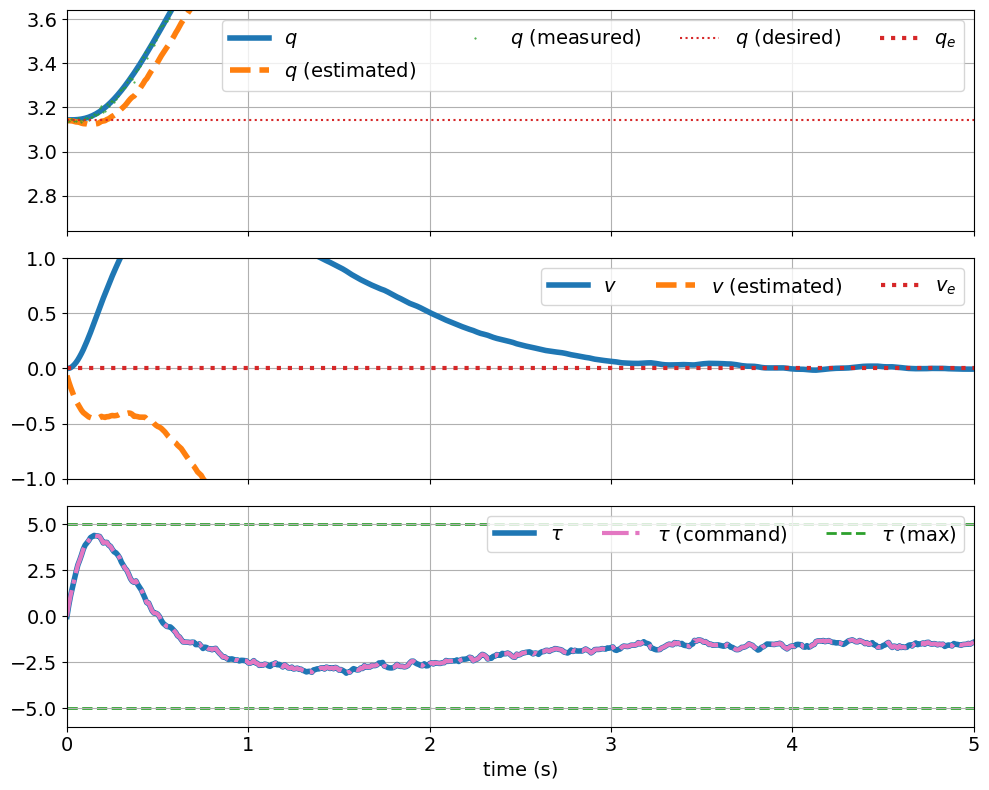

In [24]:
# Define function to get desired wheel angle
get_desired_wheel_angle = lambda t: np.pi

# Create controller
controller = Controller(A, B, C, K, L, q_e, v_e, tau_e, get_desired_wheel_angle)

# Choose initial conditions
(q_i, v_i) = (get_desired_wheel_angle(0.) + 0.002, v_e)

# Reset controller
controller.reset()

# Reset simulator
simulator.reset(
    wheel_angle=q_i,
    wheel_velocity=v_i,
    sensor_noise=0.01,
)

# Reset controller
controller.reset()

# Run simulator
data = simulator.run(
    controller,
    max_time=5.0,
)

# Show results
show_results(data, q_e, v_e, tau_e)

# What was the difference between these two cases?